# Feature Importance

This notebook performs an analysis of features that distinguish between
upskilling and reskilling programs using XGBoost and SHAP values. The analysis includes:
1. Data loading and initial exploration
2. Data preprocessing and cleaning
3. Feature importance analysis using XGBoost
4. SHAP value analysis for model interpretability

In [1]:
# Required Libraries
import pandas as pd
import numpy as np
import pyreadstat
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from collections import Counter
from sklearn.model_selection import train_test_split

# Set random seed for reproducibility
np.random.seed(42)

# Configure visualization settings
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

def add_unique_keys(label_mapping, variable_labels):
    """
    Add unique keys to label_mapping that are in variable_labels but not in label_mapping
    """
    for key in variable_labels:
        if key not in label_mapping:
            label_mapping[key] = variable_labels[key]
    return label_mapping

## 1. Data Loading and Initial Exploration

This section focuses on loading the dataset and performing initial exploratory data analysis 
to understand the structure and characteristics of our data.


Program Type Distribution:
--------------------------------------------------
program
Reskilling    673
Upskilling    464
General        72
Name: count, dtype: int64

Program Balance: 1.45:1

Number of program characteristic variables: 94


C:\Users\user\AppData\Local\Temp\ipykernel_26080\4212142211.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"\nProgram Balance: {(program_dist[0]/program_dist[1]):.2f}:1")
C:\Users\user\AppData\Local\Temp\ipykernel_26080\4212142211.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x='program', palette=['lightblue', 'lightgreen'])
C:\Users\user\AppData\Local\Temp\ipykernel_26080\4212142211.py:24: UserWarning: 
The palette list has fewer values (2) than needed (3) and will cycle, which may produce an uninterpretable plot.
  sns.countplot(data=data, x='program', palette=['lightblue', 'lightgreen'])


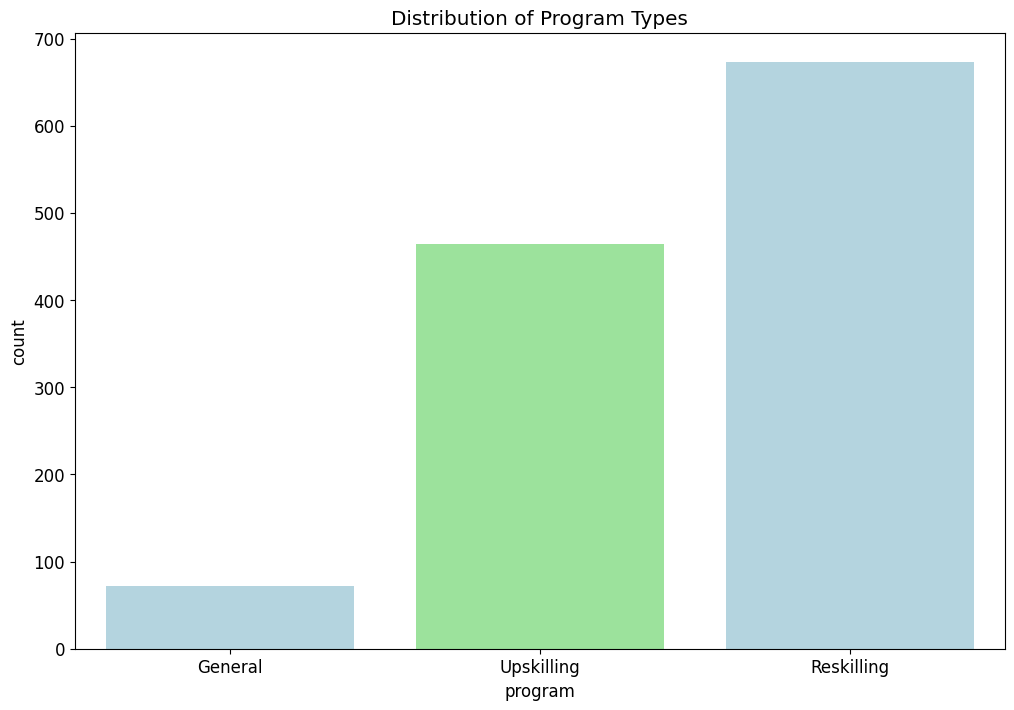


Missing values in program characteristics:
p_participated          82
p_participated_2023     82
p_mandavolunt           82
p_year_start            72
p_year_end              82
                      ... 
p_cri_individual       674
p_cha_takeup            82
p_cha_during            82
p_cha_support           82
p_cha_scale             82
Length: 90, dtype: int64


C:\Users\user\AppData\Local\Temp\ipykernel_26080\4212142211.py:64: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  full_dummies = full_dummies.replace({True: 1, False: 0})



Dataset Dimensions:
Full dataset: (1209, 760)
Program characteristics only: (1209, 190)


C:\Users\user\AppData\Local\Temp\ipykernel_26080\4212142211.py:65: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  prog_dummies = prog_dummies.replace({True: 1, False: 0})


In [2]:
def load_and_explore_data(file_path):
    """
    Load data and perform initial exploratory analysis
    focusing on program characteristics and distributions
    """
    # Load data with labels
    data = pd.read_stata(file_path)
    df, meta = pyreadstat.read_dta(file_path)
    variable_labels = dict(zip(data.columns, meta.column_labels))
    
    # Program distribution analysis
    print("\nProgram Type Distribution:")
    print("-" * 50)
    program_dist = data['program'].value_counts()
    print(program_dist)
    print(f"\nProgram Balance: {(program_dist[0]/program_dist[1]):.2f}:1")
    
    # Analyze program characteristics (p_ variables)
    prog_vars = [col for col in data.columns if col.startswith('p_')]
    print(f"\nNumber of program characteristic variables: {len(prog_vars)}")
    
    # Visualize program distribution
    plt.figure()
    sns.countplot(data=data, x='program', palette=['lightblue', 'lightgreen'])
    plt.title('Distribution of Program Types')
    plt.show()
    
    # Analyze missing values in key variables
    missing = data[prog_vars].isnull().sum()
    if missing.any() > 0:
        print("\nMissing values in program characteristics:")
        print(missing[missing > 0])
    
    return data, variable_labels, prog_vars

def preprocess_features(data, prog_vars):
    """
    Create two variants of the dataset:
    1. All variables with dummies
    2. Program characteristics only with dummies
    """
    # Create full dummy dataset
    full_dummies = pd.get_dummies(data)
    
    # Create program characteristics dummy dataset
    prog_data = data[prog_vars + ['program']]
    prog_dummies = pd.get_dummies(prog_data)
    
    # Clean column names for both datasets
    def clean_cols(df):
        new_cols = []
        for col in df.columns:
            col = (col.replace('>', 'greater')
                     .replace('<', 'less')
                     .replace(',', '_')
                     .replace(' ', '_'))
            new_cols.append(col)
        return new_cols
    
    full_dummies.columns = clean_cols(full_dummies)
    prog_dummies.columns = clean_cols(prog_dummies)
    
    # Convert boolean to numeric
    full_dummies = full_dummies.replace({True: 1, False: 0})
    prog_dummies = prog_dummies.replace({True: 1, False: 0})
    
    return full_dummies, prog_dummies

# Load and explore data
data, variable_labels, prog_vars = load_and_explore_data("../Data/V1_qualflags_analysis2_ML.dta")

# Create both dataset versions
full_dummies, prog_dummies = preprocess_features(data, prog_vars)

print("\nDataset Dimensions:")
print(f"Full dataset: {full_dummies.shape}")
print(f"Program characteristics only: {prog_dummies.shape}")

## 2. Data Preprocessing and Cleaning

This section handles data preparation, including:
- Creating dummy variables
- Cleaning column names
- Preparing target variable
- Train-test split

In [3]:
def clean_column_names(column_name):
    """
    Clean column names by replacing problematic characters
    """
    replacements = {
        '>': 'greater',
        '<': 'less',
        ',': '_',
        ' ': '_',
        '-': '_',
        '/': '_',
        '\\': '_',
        '(': '',
        ')': '',
        '[': '',
        ']': ''
    }
    
    for old, new in replacements.items():
        column_name = column_name.replace(old, new)
    return column_name

def preprocess_data(data, analyze=True):
    """
    Complete data preprocessing pipeline
    """
    # Create copy to avoid modifying original data
    df = data.copy()
    
    if analyze:
        # Display initial information about missing values
        print("\nMissing Values Before Imputation:")
        print("-" * 50)
        missing = df.isnull().sum()
        print(missing[missing > 0])
    
    # Handle missing values
    numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
    categorical_columns = df.select_dtypes(include=['object', 'category']).columns
    
    # For numeric columns, fill with median
    for col in numeric_columns:
        df[col] = df[col].fillna(df[col].median())
    
    # For categorical columns, fill with mode
    for col in categorical_columns:
        df[col] = df[col].fillna(df[col].mode()[0])
    
    # Create dummy variables for categorical columns
    df_dummies = pd.get_dummies(df)
    
    # Clean column names
    df_dummies.columns = [clean_column_names(col) for col in df_dummies.columns]
    
    # Convert boolean to integer
    df_dummies = df_dummies.replace({True: 1, False: 0})
    
    if analyze:
        print("\nDataset Shape After Preprocessing:")
        print(f"Rows: {df_dummies.shape[0]}, Columns: {df_dummies.shape[1]}")
    
    return df_dummies

def create_target(data):
    """
    Create binary target variable from program type
    """
    return np.where(data['program'] == 'Reskilling', 1, 0)

def split_data(X, y, test_size=0.2, val_size=0.2):
    """
    Split data into train, validation, and test sets
    """
    # First split: separate test set
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42, stratify=y
    )
    
    # Second split: separate validation set
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, 
        test_size=val_size, 
        random_state=42,
        stratify=y_train_val
    )
    
    return X_train, X_val, X_test, y_train, y_val, y_test

# Load data
print("Loading and preprocessing data...")
data = pd.read_stata("../Data/V1_qualflags_analysis2_ML.dta")
df, meta = pyreadstat.read_dta("../Data/V1_qualflags_analysis2_ML.dta")
variable_labels = dict(zip(data.columns, meta.column_labels))

label_mapping = {
    'roi4': 'Negative ROI',
    'roi_yes': 'ROI Measured',
    'ecp_extredeployment': 'External Redeployment',
    'p_effect_reverse': 'Program Effectiveness',
    'evp_network': 'Cross-departmental Networks',
    'roi5': 'Positive ROI',
    'sum_tr_sk': 'Sum of Trained Skills',
    'sha_b_sk_n_digital': 'Share Needed Digital Skills',
    'stat_government': 'Help Org Use Gov Subsidy',
    'ecp_intredeployment': 'Internal Redeployment',
    'stat_csr': 'Fulfilling CSR Requirement',
    'reason_dei': 'Reason DEI',
    'sk_selected': 'Total Nr skills needed',
    'stand2': 'Mix Standardization customization',
    'f_union_1 - 25%': 'Union Share 1-25%',
    'inc_mgr_nofin': 'Manager: Non-financial Incentive',
    'invest_cont': 'Continued Investment',
    'p_fund_gov': 'Funded by Government',
    'f_medium': 'Medium Firm Size (100-999)',
    'roi2': 'Not yet but intend to calculate ROI',
    'roi3': 'Tried to but unable to',
    'roi1': 'No attempt to calculate',
    'p_eligibility': 'Participation Eligibility',
    'p_targetfunc_it_Not_Selected': 'Target Function: IT not selected',
    'p_cont_investment_Very likely': 'Cont. Investment Very Likely',
    'p_adv_hr': 'Advocate HR',
    'p_participated_2023_1000 - 9999': 'Participated in 2023 (1000 - 9999)',
    'p_program_length': 'Program Length (Years)',
    'p_fund_org': 'Funded by Org',
    'p_criteria_jobtitle': 'Selection Criteria: Job Title',
    'p_criteria_assmskills': 'Selection Criteria: Assessment of Skills',
    'p_target_emp': 'Target Group: Employees',
    'p_challenge_progcompl': 'Challenge: Program Completion',
    'p_year_end_2023': 'Program End: 2023',
    'p_part': 'Number of participants',
    'p_fund_wrk': 'Funded by Worker',
    'sha_b_sk_n_soft': 'Needed share soft skill',
    'sha_b_sk_n_man': 'Needed share mgmt skill',
    'p_part_exp': 'Expected Participation',
    'tot_kpi_tracked': 'Total Nr of KPIs',
    'f_union_1___25%': 'Union share 1-25%',  # Updated label
    'p_targetfunc_it': 'Target function IT',  # Updated label
}

variable_labels = add_unique_keys(label_mapping, variable_labels)

# Display initial program distribution
print("\nProgram Type Distribution:")
print("-" * 50)
program_dist = data['program'].value_counts()
print(program_dist)
print(f"\nProgram Balance: {(program_dist['Reskilling']/program_dist['Upskilling']):.2f}:1")

# Preprocess the data
preprocessed_data = preprocess_data(data)

# Create target variable
target = create_target(data)

# Split the data
X = preprocessed_data.drop(['program_Reskilling', 'program_Upskilling', 'program_General'], axis=1, errors='ignore')
y = target

X_train, X_val, X_test, y_train, y_val, y_test = split_data(X, y)

# Print shapes of resulting datasets
print("\nDataset Shapes:")
print("-" * 50)
print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")

# Verify class distribution in all sets
print("\nClass Distribution:")
print("-" * 50)
print("Training set:", dict(Counter(y_train)))
print("Validation set:", dict(Counter(y_val)))
print("Test set:", dict(Counter(y_test)))

Loading and preprocessing data...

Program Type Distribution:
--------------------------------------------------
program
Reskilling    673
Upskilling    464
General        72
Name: count, dtype: int64

Program Balance: 1.45:1

Missing Values Before Imputation:
--------------------------------------------------
noanswerQ5_27_n1       749
noanswerQ7_29_n1       542
f_subsidy               72
p_participated          82
p_participated_2023     82
                      ... 
p_cha_during            82
p_cha_support           82
p_cha_scale             82
invest_cont             82
pcost_high              82
Length: 377, dtype: int64


C:\Users\user\AppData\Local\Temp\ipykernel_26080\3887200787.py:56: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_dummies = df_dummies.replace({True: 1, False: 0})



Dataset Shape After Preprocessing:
Rows: 1209, Columns: 760

Dataset Shapes:
--------------------------------------------------
Training set: (773, 757)
Validation set: (194, 757)
Test set: (242, 757)

Class Distribution:
--------------------------------------------------
Training set: {np.int64(0): 343, np.int64(1): 430}
Validation set: {np.int64(0): 86, np.int64(1): 108}
Test set: {np.int64(0): 107, np.int64(1): 135}


## 3. Feature Importance Analysis using XGBoost

This section implements iterative feature selection using XGBoost and analyzes 
the importance of different features in distinguishing between program types.

Training XGBoost model...
Performing iterative feature selection...
Best AUC: 0.875 with 757 features

Performing cross-validation...
Fold 1: AUC = 0.870
Fold 2: AUC = 0.865
Fold 3: AUC = 0.861
Fold 4: AUC = 0.909
Fold 5: AUC = 0.923

Mean AUC: 0.885 (+/- 0.051)

Evaluating model and generating visualizations...


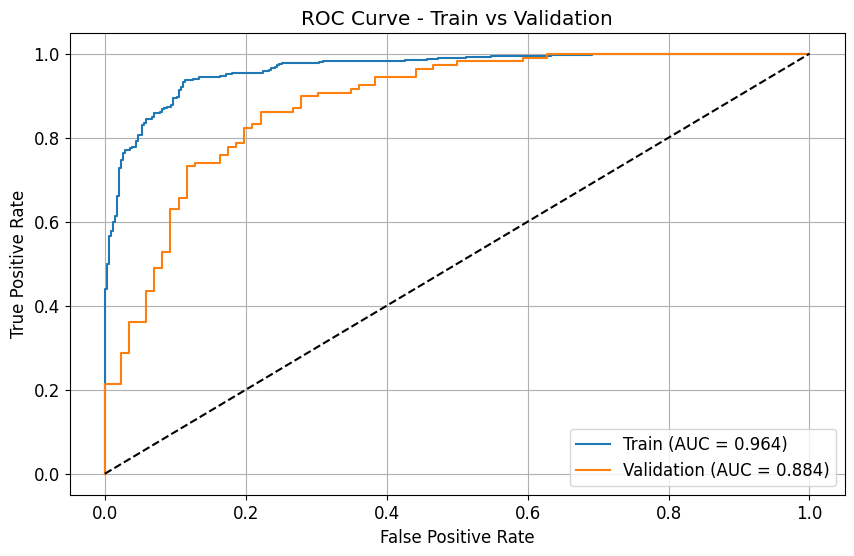

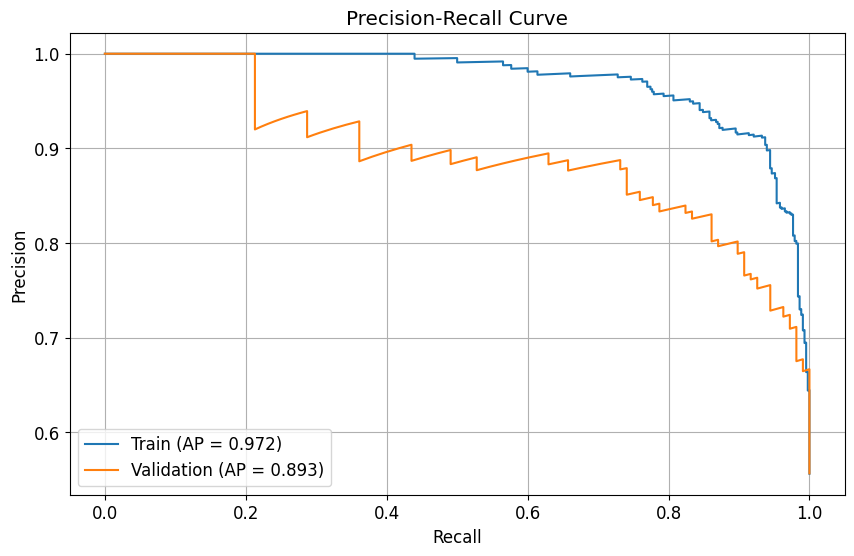

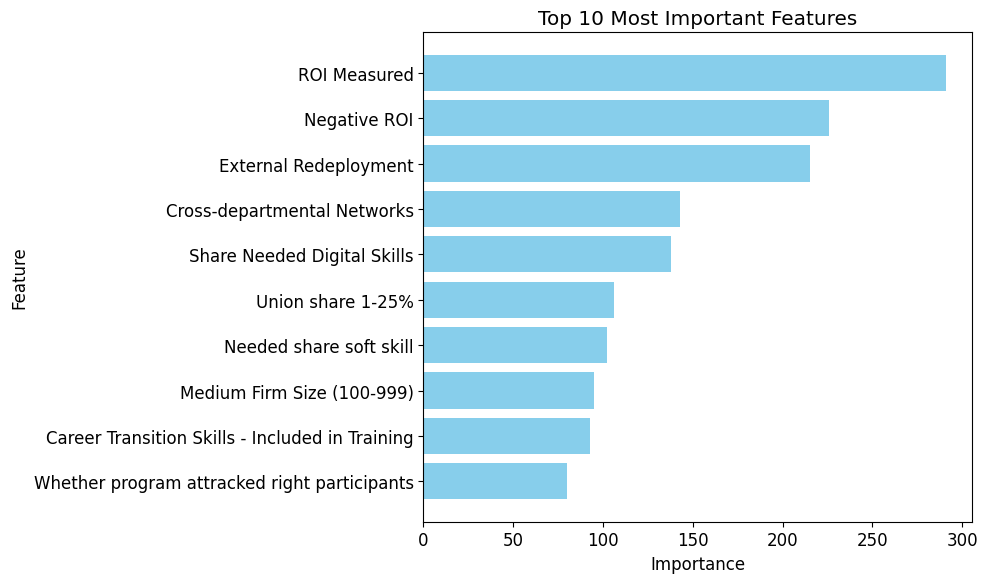

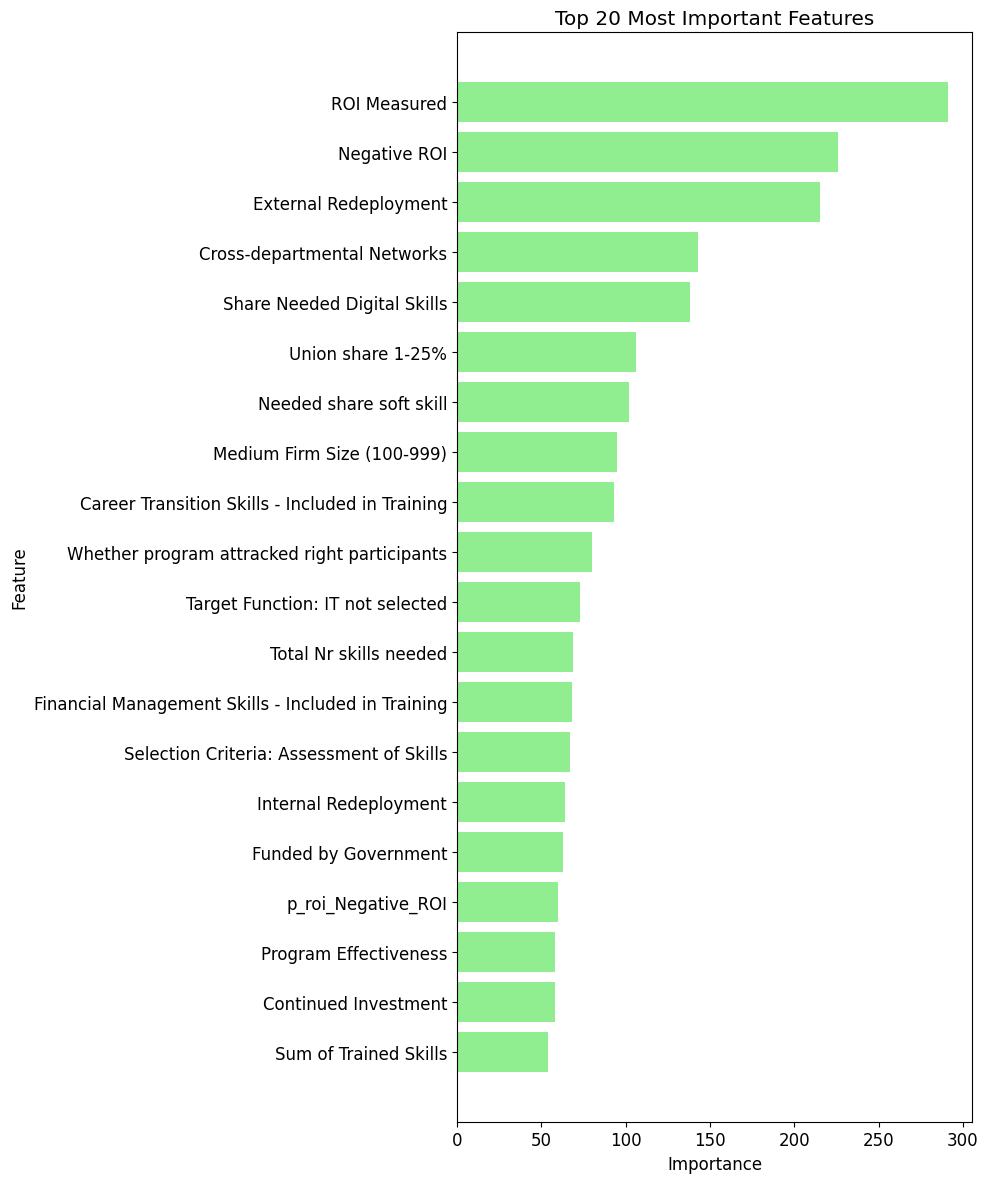


Model Performance Metrics:
Train AUC-ROC: 0.964
Validation AUC-ROC: 0.884


In [4]:
import xgboost as xgb
from sklearn.metrics import (
    roc_curve, roc_auc_score, classification_report,
    precision_recall_curve, average_precision_score
)
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


def train_xgboost_model(X_train, y_train, X_val, y_val, params=None, early_stopping_rounds=10):
    """
    Train an XGBoost model with manual cross-validation for parameter evaluation.
    """
    if params is None:
        # Default XGBoost parameters with regularization
        params = {
            'max_depth': 6,
            'learning_rate': 0.05,  # Reduced learning rate for smoother training
            'n_estimators': 1000,
            'scale_pos_weight': 1.45,  # For imbalanced data
            'subsample': 0.8,  # Use 80% of rows per tree
            'colsample_bytree': 0.8,  # Use 80% of features per tree
            'lambda': 2,  # L2 regularization
            'alpha': 1,  # L1 regularization
            'random_state': 42, # Same as Julian
            'eval_metric': ['auc', 'logloss'],
            'use_label_encoder': False
        }
    
    # Convert to pandas DataFrame/Series if data is in numpy format
    if isinstance(X_train, np.ndarray):
        X_train = pd.DataFrame(X_train)
    if isinstance(X_val, np.ndarray):
        X_val = pd.DataFrame(X_val)
    if isinstance(y_train, np.ndarray):
        y_train = pd.Series(y_train)
    if isinstance(y_val, np.ndarray):
        y_val = pd.Series(y_val)

    # Manual cross-validation using StratifiedKFold
    print("\nPerforming cross-validation...")
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    auc_scores = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train), 1):
        # Use .iloc for pandas or array slicing for numpy
        X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model_cv = xgb.XGBClassifier(**params)
        model_cv.fit(
            X_fold_train, y_fold_train,
            eval_set=[(X_fold_val, y_fold_val)],
            verbose=False
        )

        y_pred_fold = model_cv.predict_proba(X_fold_val)[:, 1]
        auc_score = roc_auc_score(y_fold_val, y_pred_fold)
        auc_scores.append(auc_score)
        print(f"Fold {fold}: AUC = {auc_score:.3f}")

    print(f"\nMean AUC: {np.mean(auc_scores):.3f} (+/- {np.std(auc_scores) * 2:.3f})")

    # Train the final model on the entire training set
    model = xgb.XGBClassifier(**params, early_stopping_rounds=early_stopping_rounds)
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=False
    )
    return model

def iterative_feature_selection(X_train, X_val, y_train, y_val, auc_threshold=1.0):
    """
    Iteratively removes features while monitoring model performance.
    """
    auc_score = 1
    best_auc = 0
    X_train_iter = X_train.copy()
    X_val_iter = X_val.copy()
    
    while auc_score >= auc_threshold:
        # Train model
        model = xgb.XGBClassifier(random_state=42)
        model.fit(X_train_iter, y_train)
        
        # Get feature importances
        feature_imps = list(zip(X_train_iter.columns, model.feature_importances_))
        
        # Remove features with importance = 1 or lowest importance
        one_list = [i[0] for i in feature_imps if i[1] == 1]
        if one_list:
            features_to_remove = one_list
        else:
            features_to_remove = [sorted(feature_imps, key=lambda x:x[1], reverse=True)[0][0]]
            
        # Calculate AUC
        y_pred_proba = model.predict_proba(X_val_iter)[:, 1]
        auc_score = roc_auc_score(y_val, y_pred_proba)
        
        if auc_score >= best_auc:
            best_auc = auc_score
            best_features = X_train_iter.columns.tolist()
            
        # Remove selected features
        X_train_iter = X_train_iter.drop(features_to_remove, axis=1)
        X_val_iter = X_val_iter.drop(features_to_remove, axis=1)
        
        if len(X_train_iter.columns) == 0:
            break
            
    return best_features, best_auc


def evaluate_and_plot(model, X_train, X_val, y_train, y_val, variable_labels):
    """
    Perform a complete evaluation of the model with metrics and visualizations.
    """
    # Predictions
    y_pred_train = model.predict_proba(X_train)[:, 1]
    y_pred_val = model.predict_proba(X_val)[:, 1]

    # 1. ROC Curve
    plt.figure(figsize=(10, 6))
    fpr_train, tpr_train, _ = roc_curve(y_train, y_pred_train)
    auc_train = roc_auc_score(y_train, y_pred_train)
    plt.plot(fpr_train, tpr_train, label=f'Train (AUC = {auc_train:.3f})')

    fpr_val, tpr_val, _ = roc_curve(y_val, y_pred_val)
    auc_val = roc_auc_score(y_val, y_pred_val)
    plt.plot(fpr_val, tpr_val, label=f'Validation (AUC = {auc_val:.3f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - Train vs Validation')
    plt.legend()
    plt.grid(True)
    plt.show()

    # 2. Precision-Recall Curve
    plt.figure(figsize=(10, 6))
    precision_train, recall_train, _ = precision_recall_curve(y_train, y_pred_train)
    ap_train = average_precision_score(y_train, y_pred_train)
    plt.plot(recall_train, precision_train, label=f'Train (AP = {ap_train:.3f})')

    precision_val, recall_val, _ = precision_recall_curve(y_val, y_pred_val)
    ap_val = average_precision_score(y_val, y_pred_val)
    plt.plot(recall_val, precision_val, label=f'Validation (AP = {ap_val:.3f})')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

    # 3. Feature Importance
    feature_importance = model.get_booster().get_score(importance_type='weight')
    # feature_importance = {
    #     variable_labels.get(k, k): v 
    #     for k, v in feature_importance.items()
    # }
    feature_importance = {
        label_mapping.get(k, k): v 
        for k, v in feature_importance.items()
    }
    sorted_features = sorted(
        feature_importance.items(), 
        key=lambda x: x[1], 
        reverse=True
    )
    # features, importances = zip(*sorted_features)
    features = [label_mapping.get(f, f) for f, _ in sorted_features]
    importances = [i for _, i in sorted_features]

    # Plot top 10 features
    plt.figure(figsize=(10, 6))
    plt.barh(features[:10][::-1], importances[:10][::-1], color='skyblue')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title('Top 10 Most Important Features')
    plt.tight_layout()
    plt.show()

    # Plot top 20 features
    plt.figure(figsize=(10, 12))  # Increased height for clarity
    plt.barh(features[:20][::-1], importances[:20][::-1], color='lightgreen')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title('Top 20 Most Important Features')
    plt.tight_layout()
    plt.show()

    return auc_train, auc_val, feature_importance

# Example Execution
print("Training XGBoost model...")
params = {
    'max_depth': 3,             # Low depth, ensures the model remains simple and avoids overfitting
    'learning_rate': 0.005,      # Slow learning rate for gradual and stable training
    'n_estimators': 1000,        # Moderate number of trees, balances performance and training time
    'min_child_weight': 7,      # Prevents splits on small, insignificant data samples
    'gamma': 0.15,               # Provides control over the minimum gain for node splits
    'subsample': 0.65,           # Uses 70% of data per tree, reducing overfitting risk
    'colsample_bytree': 0.7,    # Uses 70% of features per tree, enhancing generalization
    'lambda': 8,                # Strong L2 regularization, improves robustness
    'alpha': 2,                 # Moderate L1 regularization, encourages sparsity in weights
    'scale_pos_weight': 1.45,   # Balances the weight for imbalanced classes
    'random_state': 42,         # Ensures consistent results across runs
    'eval_metric': ['auc', 'logloss']  # Tracks model performance and error during training
}

print("Performing iterative feature selection...")
best_features, best_auc = iterative_feature_selection(X_train, X_val, y_train, y_val)
print(f"Best AUC: {best_auc:.3f} with {len(best_features)} features")

X_train = X_train[best_features]
X_val = X_val[best_features]
X_test = X_test[best_features]

# Replace with actual datasets
# X_train, y_train, X_val, y_val, variable_labels must be defined
model = train_xgboost_model(X_train, y_train, X_val, y_val, params)

print("\nEvaluating model and generating visualizations...")
auc_train, auc_val, feature_importance = evaluate_and_plot(
    model, X_train, X_val, y_train, y_val, variable_labels
)

print("\nModel Performance Metrics:")
print(f"Train AUC-ROC: {auc_train:.3f}")
print(f"Validation AUC-ROC: {auc_val:.3f}")

## 4. SHAP Value Analysis for Model Interpretability

This section uses SHAP values to provide detailed insights into feature contributions
and model decisions.

c:\Users\user\Desktop\HBS-Survey\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



Performing SHAP Value Analysis...
Calculating SHAP values...

SHAP Summary Plot (All Features):


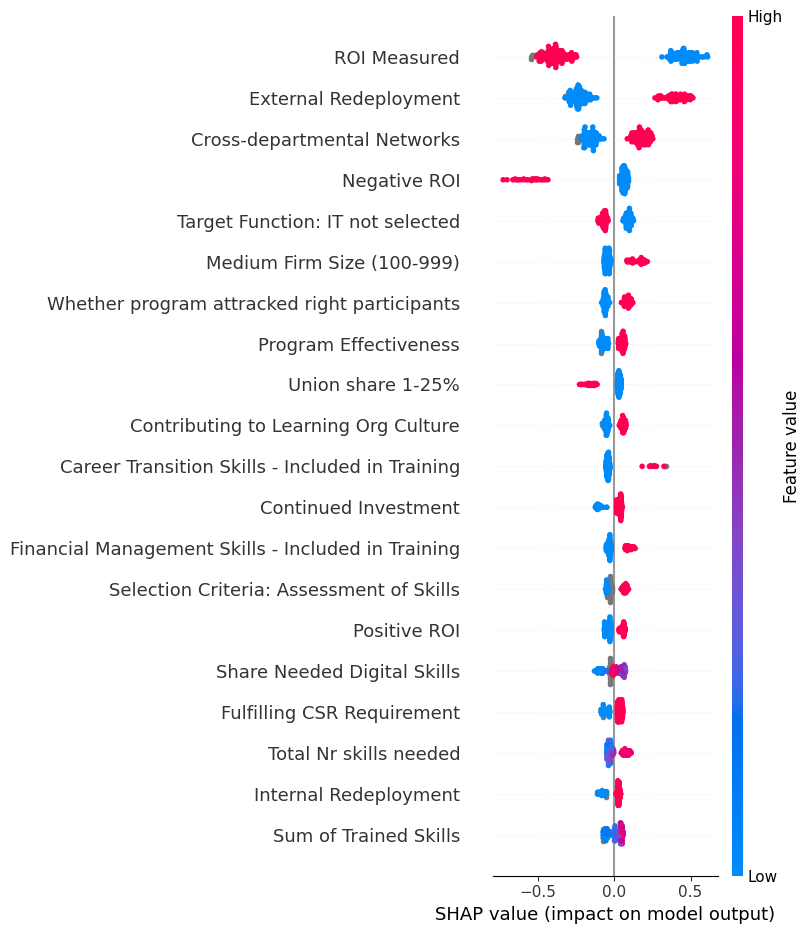


Analyzing Top 10 Features...

SHAP Bar Plot (Top 10 Features):


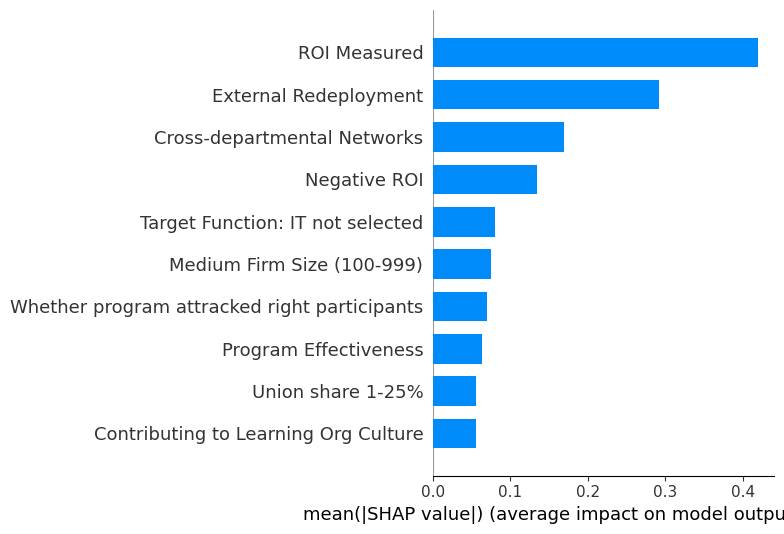


SHAP Force Plot for a Single Instance:


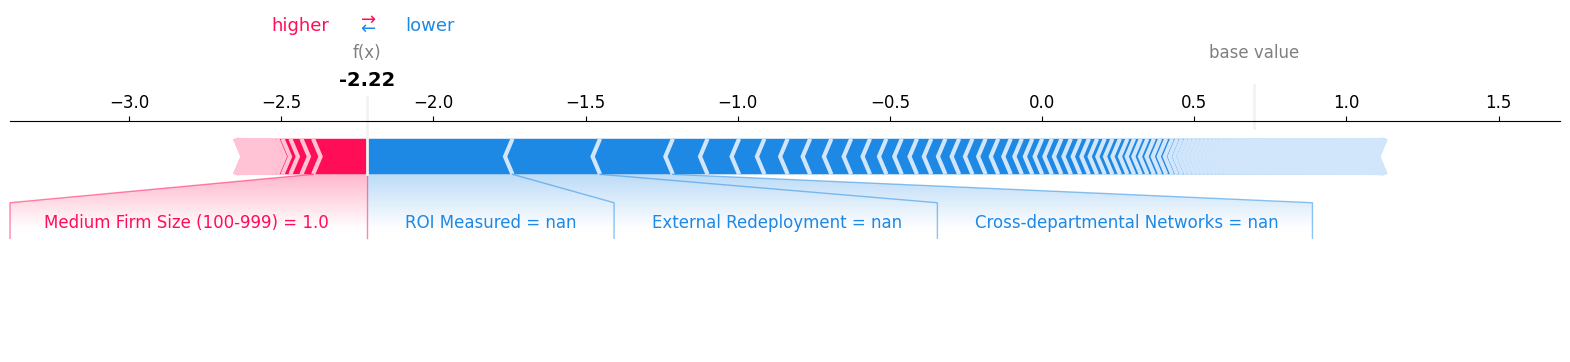

Calculating SHAP values...

SHAP Summary Plot (All Features):


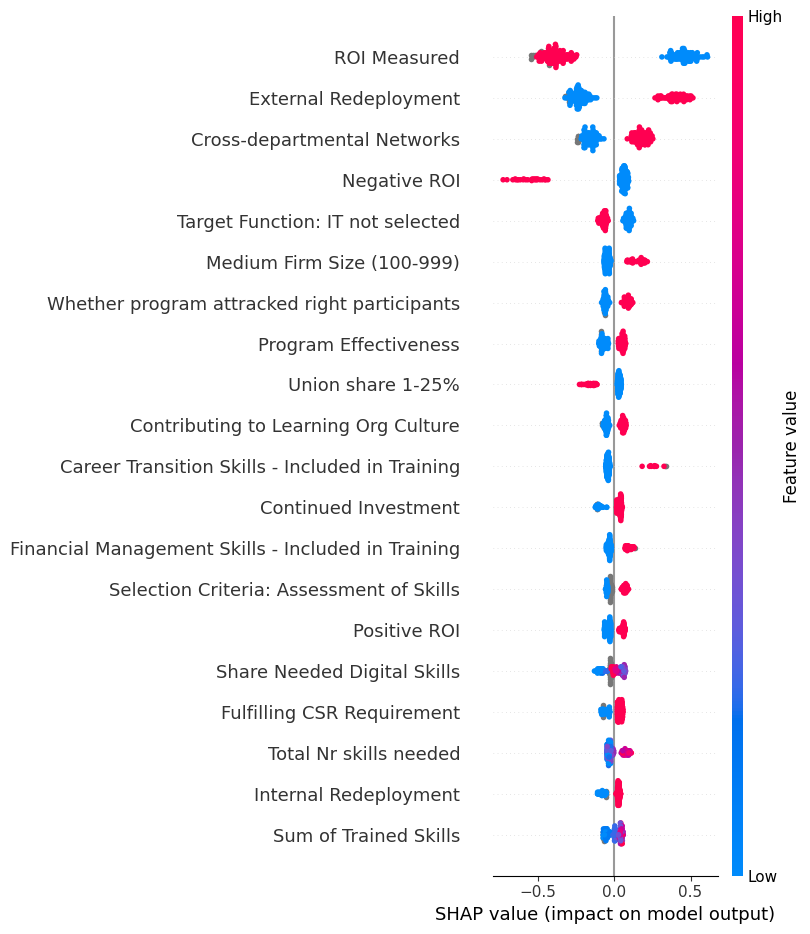


Analyzing Top 20 Features...

SHAP Bar Plot (Top 20 Features):


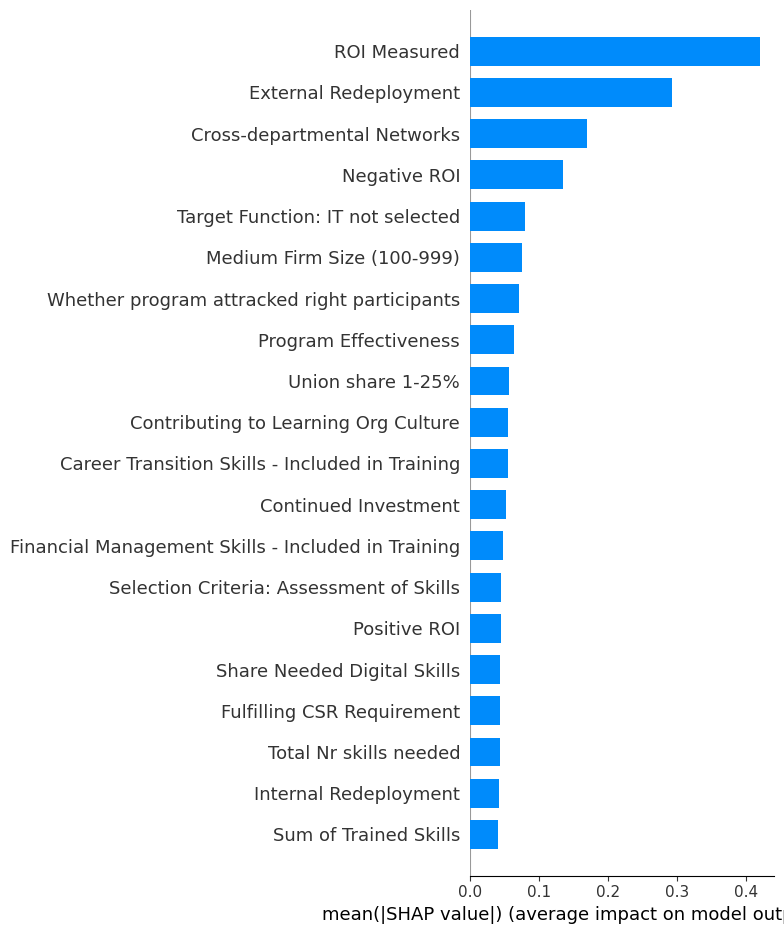


SHAP Force Plot for a Single Instance:


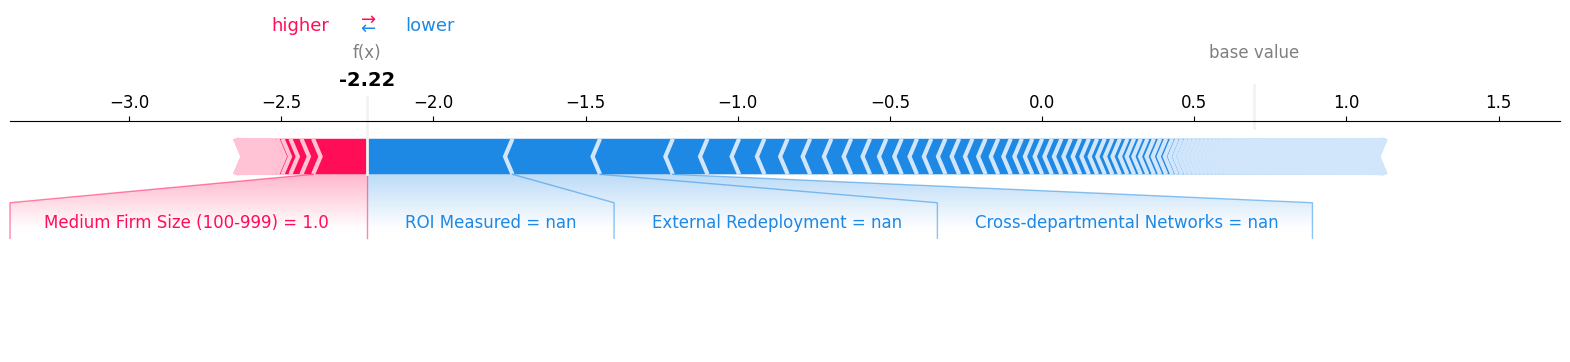

In [5]:
import shap

def shap_analysis(model, X_train, X_val, variable_labels, top_n=20):
    """
    Perform SHAP value analysis for model interpretability.
    
    Parameters:
    - model: Trained XGBoost model.
    - X_train: Training dataset (features).
    - X_val: Validation dataset (features).
    - variable_labels: Dictionary mapping feature names to readable labels.
    - top_n: Number of top features to analyze.
    """
    # Ensure SHAP uses the appropriate explainer for tree models
    explainer = shap.Explainer(model, X_train)

    # Generate SHAP values for the validation set
    print("Calculating SHAP values...")
    shap_values = explainer(X_val)

    # Summary plot for all features
    print("\nSHAP Summary Plot (All Features):")
    shap.summary_plot(
        shap_values,
        X_val,
        feature_names=[variable_labels.get(col, col) for col in X_val.columns]
    )

    # Top N features based on mean |SHAP| values
    print(f"\nAnalyzing Top {top_n} Features...")
    shap_importances = np.abs(shap_values.values).mean(axis=0)
    top_indices = np.argsort(shap_importances)[-top_n:]
    top_features = [X_val.columns[i] for i in top_indices]
    top_feature_labels = [variable_labels.get(feat, feat) for feat in top_features]

    # SHAP summary bar plot for top N features
    print(f"\nSHAP Bar Plot (Top {top_n} Features):")
    shap.summary_plot(
        shap_values[:, top_indices],
        X_val.iloc[:, top_indices],
        feature_names=top_feature_labels,
        plot_type="bar"
    )

    # Force plot for a single instance (e.g., first in validation set)
    print("\nSHAP Force Plot for a Single Instance:")
    shap.force_plot(
        explainer.expected_value,  # Expected value (base value)
        shap_values.values[0],  # SHAP values for the first instance
        X_val.iloc[0, :].astype(str),  # Convert features to strings
        feature_names=[
            variable_labels.get(col, col) for col in X_val.columns
        ],
        matplotlib=True
    )

    return top_features, shap_values


# Execute SHAP Analysis
print("\nPerforming SHAP Value Analysis...")
top_features, shap_values = shap_analysis(model, X_train, X_val, variable_labels, top_n=10)
top_features, shap_values = shap_analysis(model, X_train, X_val, variable_labels, top_n=20)